In [1]:
from Functions import *
from DataDefined import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

In [3]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])
print(encoder.classes_, encoder.transform(encoder.classes_))

#df = add_derivatives(df, delta_col)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'] [0 1 2 3 4 5 6 7 8 9]


In [4]:
## Class B versus D (where B is the known class)
X_train, y_train, X_test, y_test, X_val, y_val = getDataSplitForTwoDrivers(df, 1, 3, 42)

In [5]:
print(len(X_train), len(X_test), len(X_val))

8212 4668 5184


In [6]:
### MAKE THE PAIRS

from itertools import combinations

def create_pairs(X, source):
    """
    Function that creates pair vectors of samples in X, all combinations between samples in X are made. Pair vectors
    are made by concatenating two rows of X. The pair vectors are returned together with the labels, same_source (1) and 
    different_source (0). The label is same_source when source[sample_n] is the same as source[sample_p]; 
    if the sources are different, the label different_source is returned.
    
    return: numpy array X (features), numpy array y (labels)
    """
    # create all combinations for X and y
    X = [sample_1 + sample_2 for sample_1, sample_2 in combinations(X.tolist(), 2)]
    y = [int(group_1 == group_2) for group_1, group_2 in combinations(source.tolist(), 2)]
    return np.array(X), np.array(y)

In [7]:
X_train_np = X_train.head(400).to_numpy()
X_test_np = X_test.head(100).to_numpy()
X_val_np = X_val.head(100).to_numpy()
y_train_np = y_train.head(400).to_numpy()
y_test_np = y_test.head(100).to_numpy()
y_val_np = y_val.head(100).to_numpy()

In [8]:
X_train_pairs, y_train_pairs = create_pairs(X_train_np, y_train_np)
X_test_pairs, y_test_pairs = create_pairs(X_test_np, y_test_np)
X_val_pairs, y_val_pairs = create_pairs(X_val_np, y_val_np) 

In [11]:
print(len(X_train_pairs), len(X_test_pairs), len(X_val_pairs))

79800 4950 4950


### ONECLASS SVM

In [22]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataForSVM(df, 1, 3, 42)

NameError: name 'splitDataForSVM' is not defined

In [ ]:
X_train_np = X_train.head(400).to_numpy()
X_test_np = X_test.head(100).to_numpy()
X_val_np = X_val.head(100).to_numpy()
y_train_np = y_train.head(400).to_numpy()
y_test_np = y_test.head(100).to_numpy()
y_val_np = y_val.head(100).to_numpy()

In [ ]:
X_train_pairs, y_train_pairs = create_pairs(X_train_np, y_train_np)
X_test_pairs, y_test_pairs = create_pairs(X_test_np, y_test_np)
X_val_pairs, y_val_pairs = create_pairs(X_val_np, y_val_np) 

In [12]:
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [20]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)

oc_svm.fit(X_train_pairs, y_train_pairs)

OneClassSVM(gamma='auto', nu=0.01)

In [21]:
y_pred_test = oc_svm.predict(X_test_pairs)
print(y_pred_test[0:100])

print(y_test_pairs[0:100])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1
 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1]


In [ ]:
y_pred_test = oc_svm.predict(X_test_pairs)
y_pred_train = oc_svm.predict(X_train_pairs)

y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]
y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]

y_transf_train = [1] * len(y_train)
y_transf_test = [0] * len(y_test)

print(classification_report(y_transf_test, y_pred_test))

ValueError: Found input variables with inconsistent numbers of samples: [4668, 4950]

### TABULARNN

In [17]:
CLASS_OOD = 3 #since D is the unknown class

In [18]:
# Convert to input for the model
X_train = torch.tensor(X_train_pairs, dtype=torch.float32)
X_test = torch.tensor(X_test_pairs, dtype=torch.float32)
X_val = torch.tensor(X_val_pairs, dtype=torch.float32)

y_train = torch.tensor(y_train_pairs, dtype=torch.long)
y_test = torch.tensor(y_test_pairs, dtype=torch.long)
y_val = torch.tensor(y_val_pairs, dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)
y_val_ood = torch.where(y_val == CLASS_OOD, -1, y_val)

torch.Size([499500, 88])
torch.Size([79800, 88])
torch.Size([79800, 88])
torch.Size([499500])
torch.Size([79800])
torch.Size([79800])


In [ ]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,32)  
        self.fc4 = nn.Linear(32,2)   # Output layer: 2 classes
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x)) #
        x = self.fc4(x)
        return x

In [21]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [22]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.7  
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)

Epoch 0, Loss: 0.6910
Epoch 10, Loss: 0.5261
Epoch 20, Loss: 0.2394
Epoch 30, Loss: 0.0269
Epoch 40, Loss: 0.0015
Epoch 50, Loss: 0.0002
Epoch 60, Loss: 0.0001
Epoch 70, Loss: 0.0001
Epoch 80, Loss: 0.0001
Epoch 90, Loss: 0.0001
Epoch 100, Loss: 0.0000
Epoch 110, Loss: 0.0000
Epoch 120, Loss: 0.0000
Epoch 130, Loss: 0.0000
Epoch 140, Loss: 0.0000
Epoch 150, Loss: 0.0000
Epoch 160, Loss: 0.0000
Epoch 170, Loss: 0.0000
Epoch 180, Loss: 0.0000
Epoch 190, Loss: 0.0000
Epoch 200, Loss: 0.0000
Epoch 210, Loss: 0.0000
Epoch 220, Loss: 0.0000
Epoch 230, Loss: 0.0000
Epoch 240, Loss: 0.0000
Epoch 250, Loss: 0.0000
Epoch 260, Loss: 0.0000
Epoch 270, Loss: 0.0000
Epoch 280, Loss: 0.0000
Epoch 290, Loss: 0.0000
Epoch 300, Loss: 0.0000
Epoch 310, Loss: 0.0000
Epoch 320, Loss: 0.0000
Epoch 330, Loss: 0.0000
Epoch 340, Loss: 0.0000
Epoch 350, Loss: 0.0000
Epoch 360, Loss: 0.0000
Epoch 370, Loss: 0.0000
Epoch 380, Loss: 0.0000
Epoch 390, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 410, Loss: 0.0000
Epo

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[    0 39744]
 [    0 40056]]


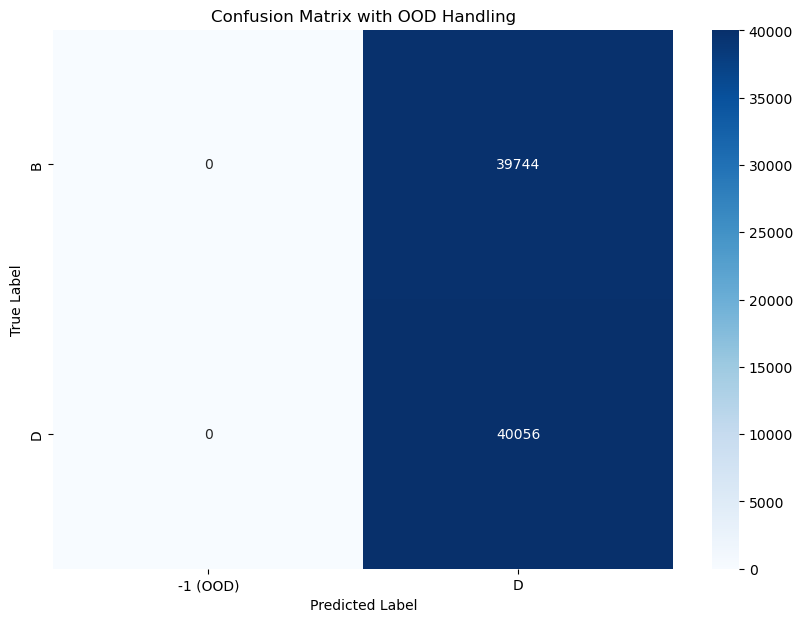

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'D', ], 
            yticklabels= ['B',  'D'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [25]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     39744
           1       0.50      1.00      0.67     40056

    accuracy                           0.50     79800
   macro avg       0.25      0.50      0.33     79800
weighted avg       0.25      0.50      0.34     79800



c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
